<a href="https://colab.research.google.com/github/kiptuidenis/SKIES/blob/main/Model_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.5 MB/s eta 0:00:00


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV

In [47]:
titanic_df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [48]:
# drop unneeded columns

titanic_df = titanic_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])



In [51]:
# Convert categorical columns to numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
titanic_df['Embarked'] = le.fit_transform(titanic_df['Embarked'])
titanic_df['Sex'] = le.fit_transform(titanic_df['Sex'])
#titanic_df = pd.get_dummies(titanic_df, drop_first=True)

# fill the missing values with median (imputation).. mean
titanic_df.fillna(titanic_df.median(), inplace=True)

# Split the dataset into training and test sets
X = titanic_df.drop(columns=['Survived'])
y = titanic_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [52]:
# check null values
titanic_df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [54]:
# Initialize the logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [67]:
# Create the param_grid
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100], # Regularization strength - Controls model complexity
    "penalty": ["l1", "l2", "elasticnet"],  # Regularization type
    "solver": ["liblinear", "saga"] # Optimizers(Decides how to find the best model) that support L1 and L2
}

In [68]:
# Grid Search Method
import time
grid_search = GridSearchCV(logreg, param_grid, cv=5) # cv - crossvalidation

# check the speed of the model
start_time = time.time()

grid_search.fit(X_train, y_train)

# Check end time
end_time = time.time()
time_taken = end_time - start_time

print("Time taken to train: ", time_taken)

Time taken to train:  0.59722900390625


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

In [69]:
# pick the best hyperparameter
print("Best Params: ", grid_search.best_params_)

Best Params:  {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


In [58]:
# Find the best model (best prediction)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", round(accuracy*100, 2), "%")

Accuracy:  79.33 %


In [59]:
### Randomized Search CV
randomized_search = RandomizedSearchCV(logreg, param_grid, cv=5, n_iter=10)
randomized_search.fit(X_train, y_train)
print("Best Params: ", randomized_search.best_params_)

Best Params:  {'solver': 'saga', 'penalty': 'l2', 'C': 0.01}


In [60]:
# Find the best model (best prediction)
best_model_r = randomized_search.best_estimator_
y_pred_r = best_model_r.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_r)
print("Accuracy: ", round(accuracy*100, 2), "%")

Accuracy:  79.33 %


In [61]:
### Bayesian Search CV
bayesian_search = BayesSearchCV(logreg, param_grid, cv=5, n_iter=10)
bayesian_search.fit(X_train, y_train)
print("Best Params: ", bayesian_search.best_params_)

Best Params:  OrderedDict([('C', 0.1), ('penalty', 'l2'), ('solver', 'saga')])


In [62]:
# Find the best model (best prediction)
best_model_b = bayesian_search.best_estimator_
y_pred_b = best_model_b.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_b)
print("Accuracy: ", round(accuracy*100, 2), "%")

Accuracy:  80.45 %


In [ ]:
########################################

**Model Optimization - Decision Trees**

**Hyperparameters**

1. Maximum tree depth ```(max_depth)``` - Height of tree. Controls how deep tree can grow. If it is too deep it overfits, too shallow it underfits

2. ```min_samples_split``` - min number of samples required to split an internal node,. It sets a limit for when the tree is allowed to keep splitting. Too low the model tends to overfit, too high the model underfits

3. ```min_samples_leaf``` - controls the minimum number of samples that should be in a leaf node. The higher the value the more general the tree becomes. It helps ensure that your final decision is not based on just a handful of data points, making more stable model.

4. ```criterion``` - defines how the tree measures

In [63]:
from sklearn.tree import DecisionTreeClassifier


In [64]:
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2
887,1,1,0,19.0,0,0,30.0000,2
888,0,3,0,28.0,1,2,23.4500,2
889,1,1,1,26.0,0,0,30.0000,0


In [66]:
# Define the Decision Tree model
dtc = DecisionTreeClassifier()

# Create the hyperparameter grid
param_grid_dtc = {
    'max_depth': range(3, 10),
    'min_samples_split': range(2, 10),
    'criterion': ['gini', 'entropy']
}

# Set up the GridSearchCV with cross-validation
grid_search_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid_dtc, cv=5)

# Fit the GridSearchCV model
grid_search_dtc.fit(X_train, y_train)

# Print the best parameters and best accuracy
print("Best Hyperparameters: ", grid_search_dtc.best_params_)
print("Best Accuracy: ", round(grid_search_dtc.best_score_ * 100, 2))

Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
Best Accuracy:  82.44


**Post-prunning/ Cost complexity pruning**

**How it works in Decision Trees**
1. Grow the full tree
2. Compute the cost complexity parameter ```ccp_alpha``` for different subtrees
3. Prune branches that contribute little to accuracy based on ```ccp_alpha```
4. Select the best pruned tree

In [71]:
## Train a model without pruning

dt_p = DecisionTreeClassifier()
dt_p.fit(X_train, y_train)

# model accuracy before pruning
print("Training Accuracy: ", dt_p.score(X_train, y_train))
print("Testing Accuracy: ", dt_p.score(X_test, y_test))


Training Accuracy:  0.9789325842696629
Testing Accuracy:  0.6089385474860335


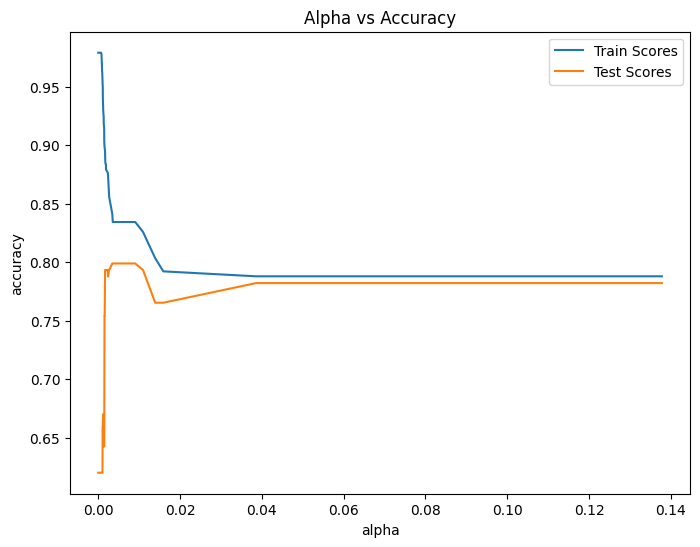

In [75]:
## Train a model with post-pruning
import matplotlib.pyplot as plt

# Get cost complexity pruning path and different alpha values
path = dt_p.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas


# Train a tree for each alpha and store accuracy
train_scores, test_scores = [], []

for alpha in ccp_alphas:
  pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
  pruned_tree.fit(X_train, y_train)

  train_scores.append(pruned_tree.score(X_train, y_train))
  test_scores.append(pruned_tree.score(X_test, y_test))

# plot alpha vs accuracy
plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas, train_scores, label="Train Scores")
plt.plot(ccp_alphas, test_scores, label="Test Scores")
plt.title("Alpha vs Accuracy")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [77]:
## Chose the best ccp_alphas to train a pruned model

best_alpha = ccp_alphas[np.argmax(test_scores)]
best_alpha

best_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
best_tree.fit(X_train, y_train)

print("Training Accuracy (after pruning):", best_tree.score(X_train, y_train))
print("Test Accuracy (after pruning):", best_tree.score(X_test, y_test))

Training Accuracy (after pruning): 0.8412921348314607
Test Accuracy (after pruning): 0.7988826815642458


It can be noted that the testing accuracy after pruning improved from 61% to 79%. The model also generalizes better than without pruning although it still overfits.